<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/S13_Attention_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нахождение лекарств, заболеваний и взаимосвязи между ними

BioBERT - трансформер, предобученный на корпусе медицинских текстов.
Поставим два замечательных пакета для работы с трансформерами

In [ ]:
!pip install -q transformers
!pip install -q simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB

Загрузим данные с гитхаба. Это данные датасета BC5CDR - текстового датасета, в котором проаннотированы слова/словосочетания, относящиеся к химическим веществам, заболеваниям и взаимосвязи между ними.

Задачей является уметь предсказывать эти слова (помечая их тегами I и B,         [подробнее](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) )

In [ ]:
import urllib.request
from pathlib import Path

def download_file(url, output_file):
  Path(output_file).parent.mkdir(parents=True, exist_ok=True)
  urllib.request.urlretrieve (url, output_file)

download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/train.txt', '/content/data/train.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/test.txt', '/content/data/test.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/dev.txt', '/content/data/dev.txt')

И напишем код для их перформатирования

In [ ]:
import pandas as pd
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = '\t', header = None, keep_default_na = False,
                    names = ['words', 'pos', 'chunk', 'labels'],
                    quoting = 3, skip_blank_lines = False)
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART- ')] # Remove the -DOCSTART- header
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

In [ ]:
train_df = read_conll('/content/data/train.txt')
test_df = read_conll('/content/data/test.txt')
dev_df = read_conll('/content/data/dev.txt')
train_df.head(100)

,words,pos,chunk,labels,sentence_id
2,Naloxone,PROPN,O,I-Entity,1
3,reverses,VERB,O,O,1
4,the,DET,O,O,1
5,antihypertensive,ADJ,O,O,1
6,effect,NOUN,O,O,1
...,...,...,...,...,...
102,not,ADV,O,O,6
103,influence,VERB,O,O,6
104,stereoselective,ADJ,O,O,6
105,binding,NOUN,O,O,6


from matplotlib import pyplot as plt
_df_0['sentence_id'].plot(kind='hist', bins=20, title='sentence_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['sentence_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'sentence_id'}, axis=1)
              .sort_values('sentence_id', ascending=True))
  xs = counted['sentence_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('sentence_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('labels')):
  _plot_series(series, series_name, i)
  fig.legend(title='labels', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('sentence_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['sentence_id'].plot(kind='line', figsize=(8, 4), title='sentence_id')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['labels'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='sentence_id', y='labels', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Посмотрим, сколько у нас данных

In [ ]:
data = [[train_df['sentence_id'].nunique(), test_df['sentence_id'].nunique(), dev_df['sentence_id'].nunique()]]

# Prints out the dataset sizes of train and test sets per label.
pd.DataFrame(data, columns=["Train", "Test", "Dev"])

,Train,Test,Dev
0,3942,4139,3949


## Обучение модели

Зададим аргументы для обучения нашей модели

In [ ]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 10,
    'train_batch_size': 32,
    'fp16': True,
    'output_dir': '/outputs/',
    'best_model_dir': '/outputs/best_model/',
    'evaluate_during_training': True,
}

In [ ]:
custom_labels = list(train_df['labels'].unique())
print(custom_labels)

['I-Entity', 'O', 'B-Entity']


Загрузим предобученную BioBert модель

In [ ]:
from simpletransformers.ner import NERModel
from transformers import AutoTokenizer
import pandas as pd
import logging

transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the bio BERT pre-trained model.
model = NERModel('bert', 'dmis-lab/biobert-v1.1', labels=custom_labels, args=train_args)



Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


И дообучим эту модель

In [ ]:
# Train the model
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping


# Дополните код
model.train_model(train_df,\
                  eval_data=dev_df,\
                  args=dict(num_train_epochs=1))

# Evaluate the model in terms of accuracy score
result, model_outputs, preds_list = model.eval_model(test_df)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/42 [00:00<?, ?it/s]

Посмотрим, что эта модель "умеет"

In [ ]:
sample = test_df[test_df.sentence_id == 10].words.str.cat(sep=' ')
print(sample)

After a single oral dose of 4 mg / kg indomethacin ( IDM ) to sodium and volume depleted rats plasma renin activity ( PRA ) and systolic blood pressure fell significantly within four hours .


In [ ]:
samples = [sample]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'After': 'O'}
{'a': 'O'}
{'single': 'O'}
{'oral': 'O'}
{'dose': 'O'}
{'of': 'O'}
{'4': 'O'}
{'mg': 'O'}
{'/': 'O'}
{'kg': 'O'}
{'indomethacin': 'I-Entity'}
{'(': 'O'}
{'IDM': 'I-Entity'}
{')': 'O'}
{'to': 'O'}
{'sodium': 'I-Entity'}
{'and': 'O'}
{'volume': 'I-Entity'}
{'depleted': 'O'}
{'rats': 'O'}
{'plasma': 'O'}
{'renin': 'O'}
{'activity': 'O'}
{'(': 'O'}
{'PRA': 'O'}
{')': 'O'}
{'and': 'O'}
{'systolic': 'O'}
{'blood': 'O'}
{'pressure': 'O'}
{'fell': 'O'}
{'significantly': 'O'}
{'within': 'O'}
{'four': 'O'}
{'hours': 'O'}
{'.': 'O'}


Видим, что модель правильно указала нам слова, относящиеся к химическим веществам

Попробуем предложение "от себя"

In [ ]:
words = "Paracetamol can cause drug-induced hepatitis"

In [ ]:
# Дополните код ниже

samples = [words]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'Paracetamol': 'I-Entity'}
{'can': 'O'}
{'cause': 'O'}
{'drug-induced': 'O'}
{'hepatitis': 'I-Entity'}


Работает!

In [ ]:
model.model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

# Получаем представление статей

При помощи трансформеров можно также получать представления целых текстов и далее анализировать их похожесть.



## Кластеризуем статьи по названию

Напишем код для скачивания с PubMed статей по заданным темам и далее визуально кластеризуем названия полученных статей

In [ ]:
from simpletransformers.language_representation import RepresentationModel
sentences = ['''
Wallerian degeneration, the progressive disintegration of distal axons and
myelin that occurs after peripheral nerve injury, is essential for creating a
permissive microenvironment for nerve regeneration, and involves cytoskeletal
reconstruction. However, it is unclear whether microtubule dynamics play a role
in this process. To address this, we treated cultured sciatic nerve explants, an
in vitro model of Wallerian degeneration, with the microtubule-targeting agents
paclitaxel and nocodazole. We found that paclitaxel-induced microtubule
stabilization promoted axon and myelin degeneration and Schwann cell
dedifferentiation, whereas nocodazole-induced microtubule destabilization
inhibited these processes. Evaluation of an in vivo model of peripheral nerve
injury showed that treatment with paclitaxel or nocodazole accelerated or
attenuated axonal regeneration, as well as functional recovery of nerve
conduction and target muscle and motor behavior, respectively. These results
suggest that microtubule dynamics participate in peripheral nerve regeneration
after injury by affecting Wallerian degeneration.
''',
'''Clinical Evaluation of the Rapid STANDARD Q COVID-19 Ag Test for the Screening of Severe Acute Respiratory Syndrome Coronavirus 2.''']
model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=False
    )
word_vectors = model.encode_sentences(sentences, combine_strategy="mean")
assert word_vectors.shape == (2, 768) # one sentence embedding per sentence

In [ ]:
word_vectors

array([[ 0.2116473 , -0.0758874 , -0.16311483, ...,  0.1054872 ,
        -0.03305118, -0.23099203],
       [ 0.07401592, -0.26707867, -0.04237314, ...,  0.08607639,
         0.08473038, -0.27609265]], dtype=float32)

Скачаем названия статей

In [ ]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.3 MB/s eta 0:00:00


In [ ]:
from Bio import Entrez

In [ ]:
def search_papers(query, retmax=200, sort='relevance', has_summary=False):
    Entrez.email = 'pdd@kodomo.fbb.msu.ru'
    handle = Entrez.esearch(db='pubmed',
                            sort=sort,
                            retmax=str(retmax),
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

def search_titles(ids):
    res = Entrez.esummary(db="pubmed", id=",".join(ids), retmode='xml')
    records = Entrez.parse(res)
    return [rec['Title'] for rec in records]

def retrieve_titles(query):
    results = search_papers(query)
    ids = results['IdList']
    return search_titles(ids)

In [ ]:
topics = ['covid19',
          'alphafold2',
          'schizophrenia',
          'drug design',
          'longevity',
          'personalized medicine',
          'cancer',
          'nanotechnology',
          'neural networks',
          'bitcoin']

topics2titles = {}
for t in topics:
  print(t)
  titles = retrieve_titles(t)
  topics2titles[t] = titles

covid19
alphafold2
schizophrenia
drug design
longevity
personalized medicine
cancer
nanotechnology
neural networks
bitcoin


In [ ]:
all_titles = sum(topics2titles.values(), [])

In [ ]:
from simpletransformers.language_representation import RepresentationModel

model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=True
    )
word_vectors = model.encode_sentences(all_titles, combine_strategy="mean")
assert word_vectors.shape == (len(all_titles), 768) # one sentence embedding per sentence

In [ ]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
from umap import UMAP

In [ ]:
umap_trans = UMAP(n_components = 2, metric="cosine")

In [ ]:
# Дополните код
X = umap_trans.fit_transform(word_vectors)


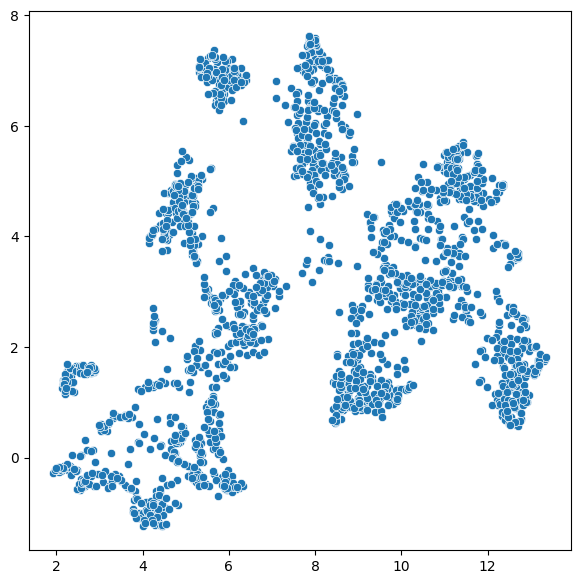

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.show()

In [ ]:
import pandas as pd

topics = []
for t, papers in topics2titles.items():
    for p in papers:
        topics.append(t)

df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "topic": topics})

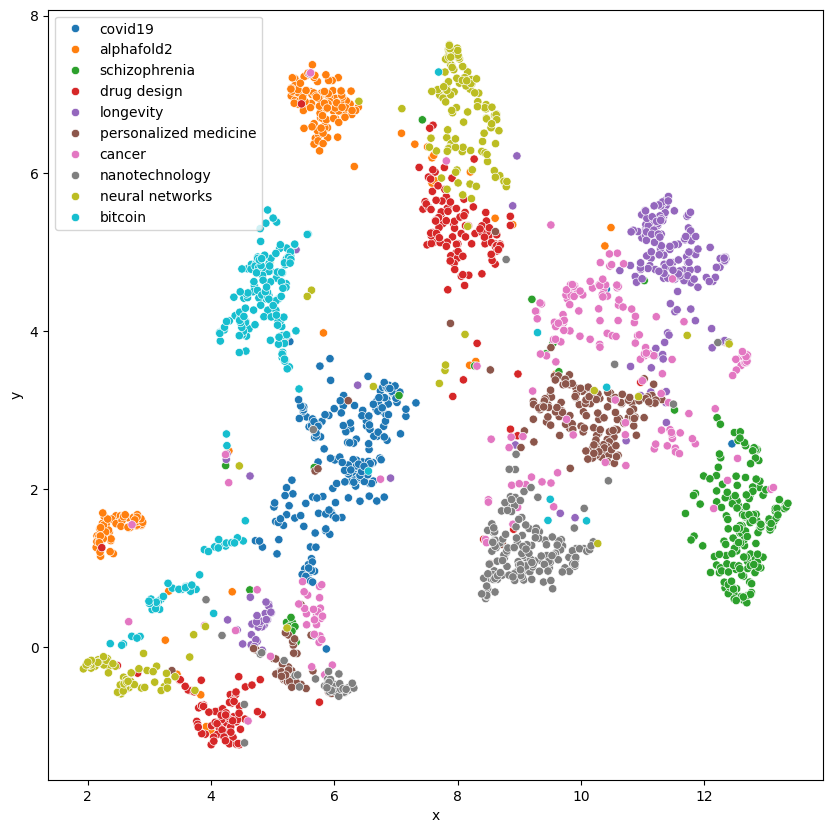

In [ ]:
# Дополните код: замените ??
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue="topic", palette=sns.color_palette("tab10"))
plt.legend()
plt.show()

## Кластеризуем статьи по абстракту


In [ ]:
def search_papers(query, retmax=200, sort='relevance'):
    Entrez.email = 'pdd@kodomo.fbb.msu.ru'
    handle = Entrez.esearch(db='pubmed',
                            sort=sort,
                            retmax=str(retmax),
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

def check_abstract(ids):
    res = Entrez.esummary(db="pubmed", id=",".join(ids), retmode='xml')
    records = Entrez.parse(res)

    return [rec['Id'] for rec in records if rec['HasAbstract']]


def retrieve_abstracts(query, has_abstract=False, retmax=200, sort='relevance'):
    results = search_papers(query, retmax, sort)
    ids = results['IdList']
    ids = check_abstract(ids)

    records = Entrez.read(Entrez.efetch(db="pubmed", id =','.join(ids), rettype="xml"))['PubmedArticle']
    abstracts = []
    for rec in records:
        try:
          abs = rec['MedlineCitation']['Article']['Abstract']['AbstractText']
          abs = " ".join(abs)
          abstracts.append(abs)
        except KeyError:
          continue
    return abstracts

In [ ]:
res = retrieve_abstracts("drug design")
print(len(res))

146


In [ ]:
topics = ['covid19',
          'alphafold2',
          'schizophrenia',
          'drug design',
          'longevity',
          'personalized medicine',
          'cancer',
          'nanotechnology',
          'neural networks',
          'bitcoin']

topics2abstracts = {}
for t in topics:
  print(t)
  abstracts = retrieve_abstracts(t)
  topics2abstracts[t] = abstracts

covid19
alphafold2
schizophrenia
drug design
longevity
personalized medicine
cancer
nanotechnology
neural networks
bitcoin


In [ ]:
all_abstracts = sum(topics2abstracts.values(), [])

In [ ]:
from simpletransformers.language_representation import RepresentationModel

model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=True
    )
word_vectors = model.encode_sentences(all_abstracts, combine_strategy="mean")
assert word_vectors.shape == (len(all_abstracts), 768) # one sentence embedding per sentence

In [ ]:
umap_trans = UMAP(n_components = 2, metric="cosine")
X = umap_trans.fit_transform(word_vectors)


In [ ]:
topics = []
for t, papers in topics2abstracts.items():
    for p in papers:
        topics.append(t)

df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "topic": topics})

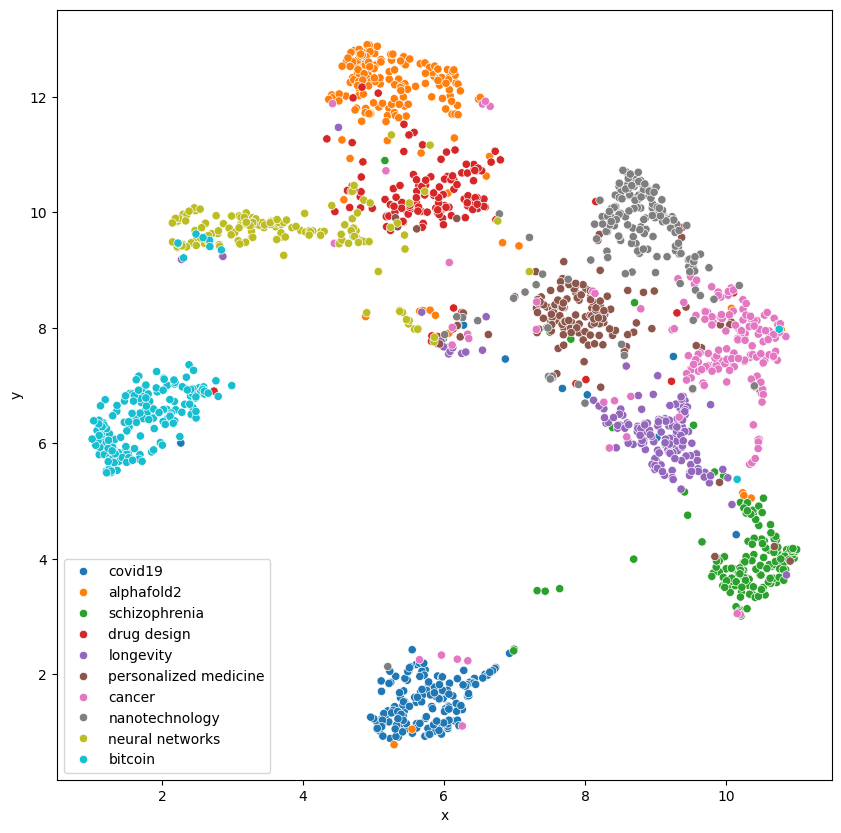

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue="topic", palette=sns.color_palette("tab10"))
plt.legend()
plt.show()

# Self-supervised сегментация при помощи DINO

In [ ]:
!git clone https://github.com/facebookresearch/dino

Cloning into 'dino'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (175/175), 24.47 MiB | 35.19 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
!python dino/visualize_attention.py

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth
100% 82.7M/82.7M [00:00<00:00, 201MB/s]
Please use the `--image_path` argument to indicate the path of the image you wish to visualize.
Since no image path have been provided, we take the first image in our paper.
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


In [ ]:
from IPython.display import Image


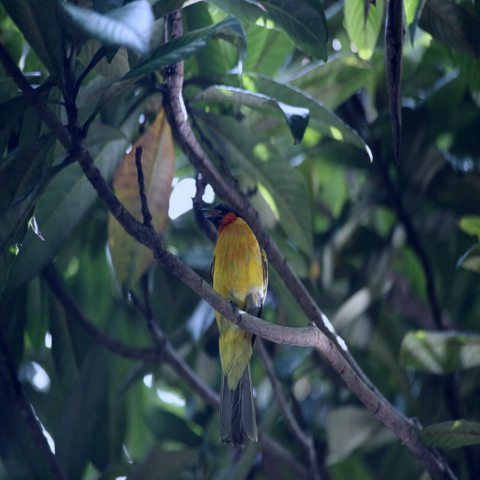

In [ ]:

Image(filename=f"./img.png" )

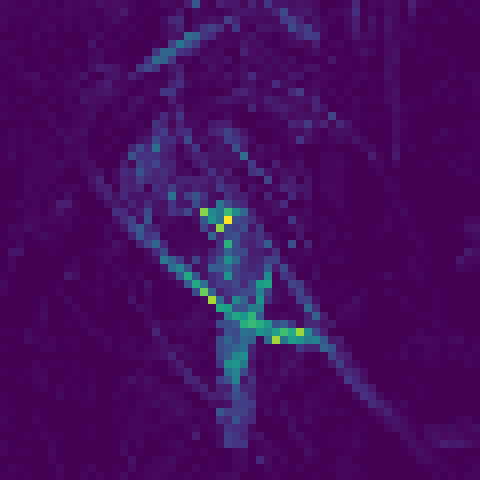

In [ ]:

Image(filename=f"./attn-head0.png")

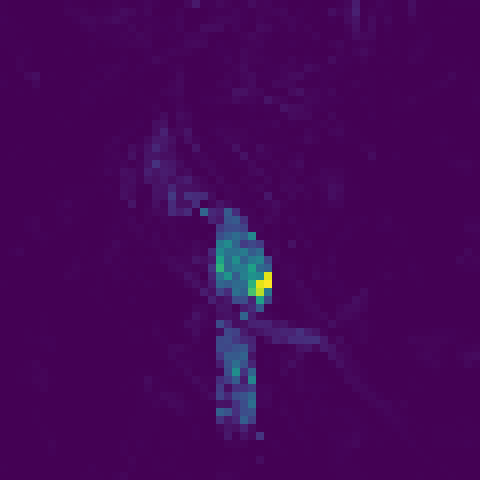

In [ ]:

Image(filename=f"./attn-head1.png")

Видим, что действительно исходное изображение сегментируется.

Можем использовать нейросеть чтобы натренировать лучшие распознаватели птиц/растений и т.д.

А что если подать на вход медицинское изображение, похожего на которое вообще не было в датасете?

In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/lung.jpeg

--2024-04-22 08:03:46--  https://kodomo.fbb.msu.ru/FBB/year_20/ml/lung.jpeg
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116816 (114K) [image/jpeg]
Saving to: ‘lung.jpeg’

lung.jpeg           100%[===================>] 114.08K   281KB/s    in 0.4s    

2024-04-22 08:03:48 (281 KB/s) - ‘lung.jpeg’ saved [116816/116816]



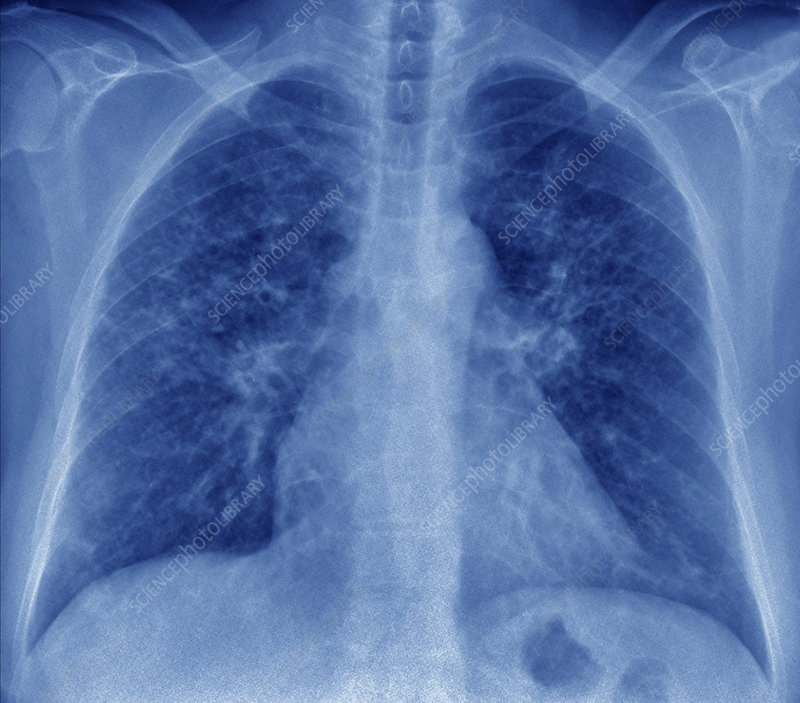

In [ ]:
Image(filename="lung.jpeg")

In [ ]:
!python dino/visualize_attention.py --image_path lung.jpeg

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


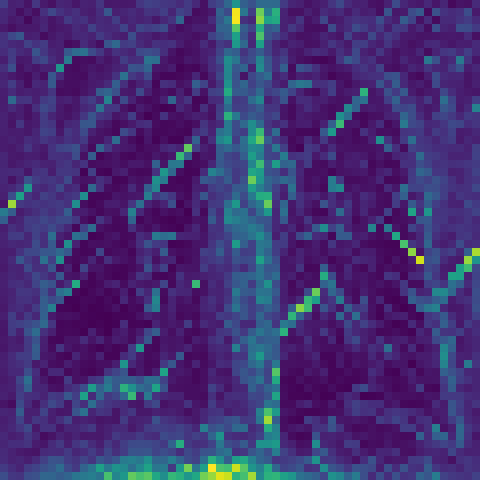

In [ ]:
Image(filename=f"./attn-head1.png")

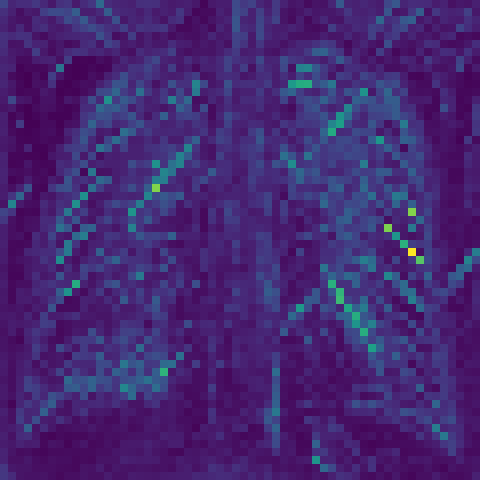

In [ ]:
Image(filename=f"./attn-head2.png")

Внезапно - сегментация тоже хорошая.

Мы можем использовать эту сеть для доменов, которые она в принципе не видела!

# AlphaFold2

Ну и, наконец, AlphaFold2.

Воспользуемся ноутбуком, выложенным в публичный доступ Сергеем Овчинниковым - [ссылка](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)

В этом ноутбуке все полностью автоматизировано

## Победы AlphaFold2

Не включайте template search, иначе совсем нечестно

In [ ]:
seq1 = "TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEIKTFTVTE"
seq2 = "TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE"

In [ ]:
for ind, (s1, s2) in enumerate(zip(seq1, seq2) ):
  if s1 != s2:
    print(f"Differ: {s1}{ind}{s2}")

Differ: L19A
Differ: I29F
Differ: L44Y


Должно получиться как в [этой статье](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2779201/)

Конечно, можно заметить, что при обучении модель видела структуры, выложенные в PDB. Но у AlphaFold бывают успехи и на структурах, которые еще не были опубликованы и при этом сложны.

## Поражения AlphaFold2

Промоделируйте следующую последовательность:



In [ ]:
seq = '''MDQNNSLPPYAQGLASPQGAMTPGIPIFSPMMPYGTGLTPQPIQNTNSLSILEEQQRQQQ
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQAVAAAAVQQSTSQQATQGTSGQAPQ
LFHSQTLTTAPLPGTTPLYPSPMTPMTPITPATPASESSGIVPQLQNIVSTVNLGCKLDL
KTIALRARNAEYNPKRFAAVIMRIREPRTTALIFSSGKMVCTGAKSEEQSRLAARKYARV
VQKLGFPAKFLDFKIQNMVGSCDVKFPIRLEGLVLTHQQFSSYEPELFPGLIYRMIKPRI
VLLIFVSGKVVLTGAKVRAEIYEAFENIYPILKGFRKTT'''

Сравните с тем, что [должно](https://twitter.com/PappulabWashU/status/1418332465740066816/photo/2) получиться

# *Получаем представления белков

Кроме этого, есть модели, которые self-supervised натренированы на биологических последовательностях.

Самая известная из них, разумеется, AlphaFold2, которая тоже внутри себя использует натренированную таким образом подсеть.

Однако есть и более "простые" модели, например, модель от FacebookAI - ESM1b

In [ ]:
!pip install fair-esm

In [ ]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm", "esm1b_t33_650M_UR50S")

Using cache found in /root/.cache/torch/hub/facebookresearch_esm_main


In [ ]:
device = torch.device("cuda")

In [ ]:
import torch
import esm

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.to(device)
batch_converter = alphabet.get_batch_converter()

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEEKALTARQQEVFDLIRDHISQTGMPPTRAEIAQ"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, (_, seq) in enumerate(data):
        sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0).cpu() )


In [ ]:
print(sequence_representations)

In [ ]:
print(sequence_representations[0].shape)

Точно так же, при помощи полученных представлений, белки можно сравнивать.
Можно использовать полученные представления

Можем взять несколько семейств белков и посмотреть, разделятся ли они в латентном пространстве.

А можно попытаться, например, предсказать температуру плавления белка.

Возьмем датасет, препроцессированный при помощи пакета DeepChem

In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/protein_melt.fasta

--2024-04-22 09:05:11--  https://kodomo.fbb.msu.ru/FBB/year_20/ml/protein_melt.fasta
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 303109 (296K)
Saving to: ‘protein_melt.fasta’

protein_melt.fasta  100%[===================>] 296.00K  1.78MB/s    in 0.2s    

2024-04-22 09:05:12 (1.78 MB/s) - ‘protein_melt.fasta’ saved [303109/303109]



In [ ]:
!pip install BioPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.7 MB/s eta 0:00:00


In [ ]:
from Bio import SeqIO

In [ ]:
X = []
y = []
for seq in SeqIO.parse("protein_melt.fasta", "fasta"):
    X.append( (seq.id, str(seq.seq)))
    y.append(float(seq.description.split("melt:")[-1]))


In [ ]:
X_repr = []

In [ ]:
!nvidia-smi

Mon Apr 22 09:05:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
step = 1
for ind in range(0, len(X), step):
  print(ind)
  batch_labels, batch_strs, batch_tokens = batch_converter(X[ind:ind+step])

  # Extract per-residue representations (on CPU)
  with torch.no_grad():
      results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
      token_representations = results["representations"][33]
      # Generate per-sequence representations via averaging
      # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
      sequence_representations = []
      for i, (_, seq) in enumerate(X[ind:ind+step]):
          sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0).cpu())
      X_repr.append(sequence_representations)


0


NameError: name 'batch_converter' is not defined

In [ ]:
X_embed = [x[0].unsqueeze(0) for x in X_repr]

In [ ]:
X_embed = torch.cat(X_embed, dim=0).numpy()

Есть два варианта разбить датасет. Какой правильнее? Указание - посмотрите на идентификаторы последовательностей  

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_embed, y)

ValueError: Found input variables with inconsistent numbers of samples: [0, 1488]

In [ ]:
val_start = int(X_embed.shape[0] * (1 - 0.8))
X_train, X_test, y_train, y_test = X_embed[:val_start], X_embed[val_start:], y[:val_start], y[val_start:]

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
from sklearn.linear_model import SGDRegressor

In [ ]:
model = SGDRegressor().fit(X_train, y_train)
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f"MAE: {mae}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor